In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg as LA
import argparse
from scutils import best_response
from scutils import SC_solver

from cf_matrix import make_confusion_matrix as mkcfmat
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate data
we used seeds 6 and 27 in the figures in the paper. The choice of the seed impacts the observations we make of course. 


In [5]:
N = 1000
N_test = 100
# Set the dimension
d = 2
seed= 6 #980 #  6 27
np.random.seed(seed) #10, (8,100)


# Generate training data matrix X_train
X_f = np.random.randn(N, d)
One = np.ones((N,1))
X_full = np.append(X_f,One,axis=1)

# Generate ground truth theta_ground_truth
theta_ground_truth = np.random.randn(d+1, 1)

# X_full = np.random.randn(N, d)
# Generate outputs y_train
Y_full = (np.sign(X_full@ theta_ground_truth + 0.1 * np.random.randn(N, 1))+1)/2

if len(np.where(Y_full==0.0)[0])>=len(np.where(Y_full==1.0)[0]):
    nzero=len(np.where(Y_full==1.0)[0])
    w=1.0
    
else:
    nzero=len(np.where(Y_full==0.0)[0])
    print(nzero)
    w=0.0

#X_full[np.where(Y_full==1.0)[0][0:nzero]]
X_full_=np.vstack((X_full[np.where(Y_full==1.0)[0][0:nzero]], X_full[np.where(Y_full==0.0)[0][0:nzero]]))
Y_full_=np.vstack((Y_full[np.where(Y_full==1.0)[0][0:nzero]], Y_full[np.where(Y_full==0.0)[0][0:nzero]]))

# Generate training data matrix X_train
X_testT = np.random.randn(N_test, d)
OneT = np.ones((N_test,1))
X_test = np.append(X_testT,OneT,axis=1)
# Generate outputs y_train
y_test = (np.sign(X_test@ theta_ground_truth + 0.1 * np.random.randn(N_test, 1))+1)/2

strat_features = np.array([1,2]) - 1
#strat_features=[]
# One = np.ones((N,1))
bal=len(np.where(Y_full_==0.0)[0])
print(bal)
X_test=np.vstack((X_full_[0:50], X_full_[bal:bal+50]))
y_test=np.vstack((Y_full_[0:50], Y_full_[bal:bal+50]))

X_train=np.vstack((X_full_[50:bal], X_full_[bal+50:len(Y_full_)]))
y_train=np.vstack((Y_full_[50:bal], Y_full_[bal+50:len(Y_full_)]))
# X_full = np.append(X_f,One,axis=1)
N_train=int(bal*2-N_test)

# split into 2/3-1/3
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_full_, Y_full_, test_size=0.33)
N_train=len(y_train)
N_test=len(y_test)

446


In [6]:
# Plotting the classifier 
def classifier_line(theta_FO, bdd=(-1,1)):
    numPoints = 100
    X1_classifier = np.linspace(bdd[0],bdd[1],numPoints)
    X2_classifier = np.zeros((numPoints,1))
    ratio = -theta_FO[0]/theta_FO[1]
    for j in range(numPoints):
        X2_classifier[j] = (-theta_FO[2]-theta_FO[0]*X1_classifier[j])/theta_FO[1]
    return X1_classifier,X2_classifier

#X1_Robust,X2_Robust=classifier_plotter(theta_FO) 



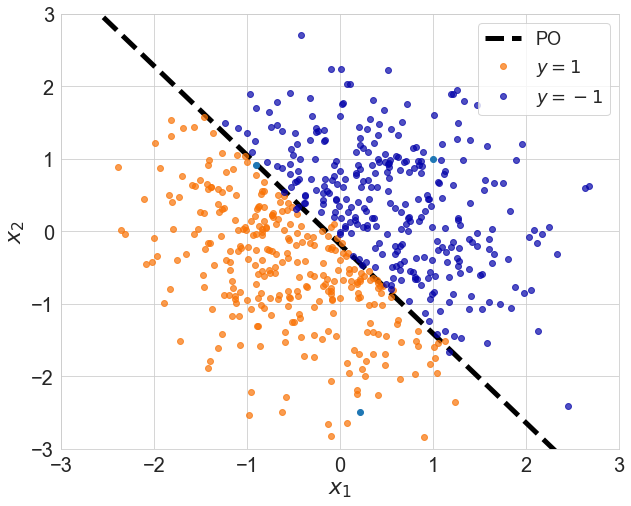

In [7]:
# Plot the ground truth data distribution

        
X_test_=X_train #best_response(X_train ,2*y_train.reshape((N_train, 1))-1,theta_ground_truth, strat_features=strat_features,zeta=zeta)


Xp = X_test_[np.where(y_train==1)[0],0]
Yp = X_test_[np.where(y_train==1)[0],1]
Xm = X_test_[np.where(y_train==0)[0],0]
Ym = X_test_[np.where(y_train==0)[0],1]
plt.figure(figsize=(10,8))
sns.set_style("whitegrid")
X1_PO, X2_PO=classifier_line(theta_ground_truth, bdd=(-3,3))
plt.plot(X1_PO,X2_PO, label='PO', color='xkcd:black', linewidth=5, linestyle='--')
plt.plot(Xp,Yp,'.', markersize=12, color='xkcd:orange', label=r'$y=1$', alpha=0.7)
plt.plot(Xm,Ym,'.',markersize=12, color='xkcd:royal blue', label=r'$y=-1$', alpha=0.7)
plt.plot(X_full_[0], X_full_[1],'.', markersize=12)
plt.tick_params(labelsize=20)
plt.xlabel(r'$x_1$', fontsize=22)
plt.ylabel(r'$x_2$', fontsize=22)
plt.legend(fontsize=18)
plt.xlim([-3,3])
plt.ylim([-3,3])
for tag in ['png','pdf']:
    plt.savefig('seed={}_original_final.'.format(seed)+tag, transparent=True, dpi=300, bbox_inches='tight')

## Strategic Classification
Run the strategic classification problem with our method and to compute the PO point

In [8]:

reg_factor = 1/N_train
u_init = []
epochs_PP = 1000
N = len(Y_full_)


zeta = 0.1  # Power of best response of agent 

zeta = zeta
reg_factor=1/np.shape(X_train)[0]
M=2*np.linalg.norm(X_train)/np.shape(X_train)[0]+2*reg_factor*1000 # R=1000 is the bound on Theta
eta_init_PP = 1/M

# performative optimal point
theta_final, loss_final, theta_lst,loss_lst = SC_solver(X_train,2*y_train.reshape((N_train, 1))-1,zeta=zeta, 
                                                        eta=eta_init_PP, EPOCH=epochs_PP, strat_features = strat_features,
                                                        u_init=u_init,reg_factor=reg_factor, theta_gt=theta_ground_truth)

theta_final_all={}
classifiers={}
losses={}
deltas=[ 0.5, 0.95, 0.99 ]
n_epochs=[20]
for n_epoch in n_epochs:
    for mixing in deltas:
        print("mixing value : ", mixing, " n epoch : ", n_epoch)
        theta_final_d, loss_final_d, theta_lst_d,loss_lst_d, X_train_dynamic_all = SC_solver(X_train,2*y_train.reshape((N_train, 1))-1,zeta=zeta,mixing=mixing,
                                                                                             n_epoch=n_epoch, eta=eta_init_PP, 
                                                                    EPOCH=epochs_PP, strat_features = strat_features,u_init=u_init,reg_factor=reg_factor,
                                                                    dynamic=True, loc=1.0, scale=45.0, seed=seed, theta_gt=theta_ground_truth.T) #45
        theta_final_all[(mixing,n_epoch)]=theta_final_d
        X1_PP, X2_PP = classifier_line(theta_final_d, bdd=(-3,3))
        classifiers[(mixing,n_epoch)]=(X1_PP,X2_PP)
        losses[(mixing,n_epoch)]=loss_lst_d
        print("theta final : ", theta_final_d.T)
        print()


mixing value :  0.5  n epoch :  20
theta final :  [[-2.41291572 -1.93300768 -0.66428361]]

mixing value :  0.95  n epoch :  20
theta final :  [[-1.87236092 -1.49256514 -0.42749144]]

mixing value :  0.99  n epoch :  20
theta final :  [[-0.81057909 -0.64040992 -0.11255342]]



## Plot the Losses

lossconvergence_seed=6_n_epoch=20_new
lossconvergence_seed=6_n_epoch=20_new


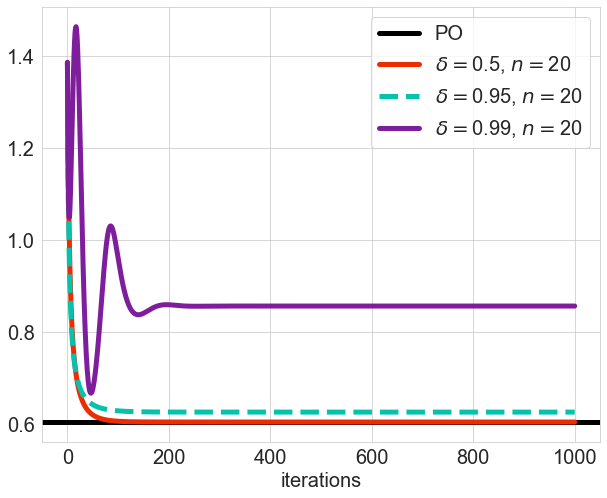

In [290]:
cols=['xkcd:tomato red', 'xkcd:turquoise', 'xkcd:purple', 'xkcd:hot pink']
for n_epoch in n_epochs:
    plt.figure(figsize=(10,8))
    plt.axhline(y=loss_final, color='k', linewidth=5, label='PO')
    for i,mixing in enumerate(deltas):
        if i==1:
            ls='--'
        else:
            ls='-'
        plt.plot(losses[(mixing,n_epoch)], label=r'$\delta=${}, $n=${}'.format(mixing,n_epoch), color=cols[i], linewidth=5, ls=ls)
    
    plt.legend(fontsize=20)
    plt.tick_params(labelsize=20)
    plt.xlabel('iterations', fontsize=20)
    for tag in ['png', 'pdf']:
        print('lossconvergence_seed={}_n_epoch={}_new'.format(seed,n_epoch))
        plt.savefig('lossconvergence_seed={}_n_epoch={}_final'.format(seed,n_epoch)+'.'+tag, transparent=True, dpi=300)

### Plotting the classifiers and data distributions

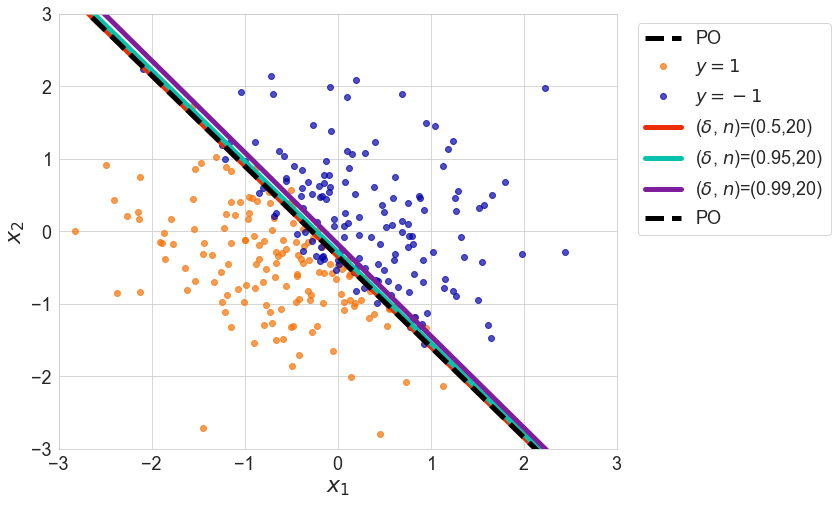

In [294]:
# creates a single plot

def classifier_plotter(X_test,y_test, classifiers, theta_final=theta_final):
    Xp = X_test[np.where(y_test==1)[0],0]
    Yp = X_test[np.where(y_test==1)[0],1]
    Xm = X_test[np.where(y_test==0)[0],0]
    Ym = X_test[np.where(y_test==0)[0],1]
    plt.figure(figsize=(10,8))
    sns.set_style("whitegrid")
    X1_PO, X2_PO=classifier_line(theta_final, bdd=(-3,3))
    cols_=['xkcd:tomato red', 'xkcd:turquoise', 'xkcd:purple', 'xkcd:hot pink']
    plt.plot(X1_PO,X2_PO, '--',label='PO', color='xkcd:black', linewidth=5)
    plt.plot(Xp,Yp,'.', markersize=12, color='xkcd:orange', label=r'$y=1$', alpha=0.7)
    plt.plot(Xm,Ym,'.',markersize=12, color='xkcd:royal blue', label=r'$y=-1$', alpha=0.7)
    #plt.plot(X1_Robust,X2_Robust)
    cols=['xkcd:golden rod', 'xkcd:tomato red', 'xkcd:purple', 'xkcd:hot pink']
    lss=['-','--','-.', ':']
    alphas=[0.6,0.7,0.9,1.0]
    for i,mixing in enumerate(deltas):
        col=cols_[i]
        for ii,n_epoch in enumerate(n_epochs):
            ls=lss[ii]
        
            (X1_PP, X2_PP)=classifiers[(mixing, n_epoch)]
            
            plt.plot(X1_PP,X2_PP, label='($\delta$, $n$)=({},{})'.format(mixing,n_epoch), linewidth=5, color=col, ls=lss[ii], alpha=1.0)
    #plt.plot(X1_PP_d, X2_PP_d)
    #plt.legend(['Data Points +1','Data Points -1','Static', 'Dynamic'])
    plt.plot(X1_PO,X2_PO, '--',label='PO', color='xkcd:black', linewidth=5)
X_perf = best_response(X_test ,2*y_test.reshape((N_test, 1))-1,theta_final, strat_features=strat_features,zeta=zeta)
#X_perf_ = best_response(X_test ,2*y_test.reshape((N_test, 1))-1,theta_final_d, strat_features=strat_features,zeta=0)
classifier_plotter(X_perf,y_test,classifiers)
plt.legend(fontsize=18, loc=1, bbox_to_anchor=(1.4,1))
plt.tick_params(labelsize=18)
plt.xlabel(r'$x_1$', fontsize=22)
plt.ylabel(r'$x_2$', fontsize=22)
plt.xlim([-3,3])
plt.ylim([-3,3])
for tag in ['pdf','png']:
    plt.savefig('classiferplot_d=2_N=1000_seed={}_nepoch={}_final'.format(seed,n_epoch)+'.'+tag, bbox_inches='tight', transparent=True, dpi=300)

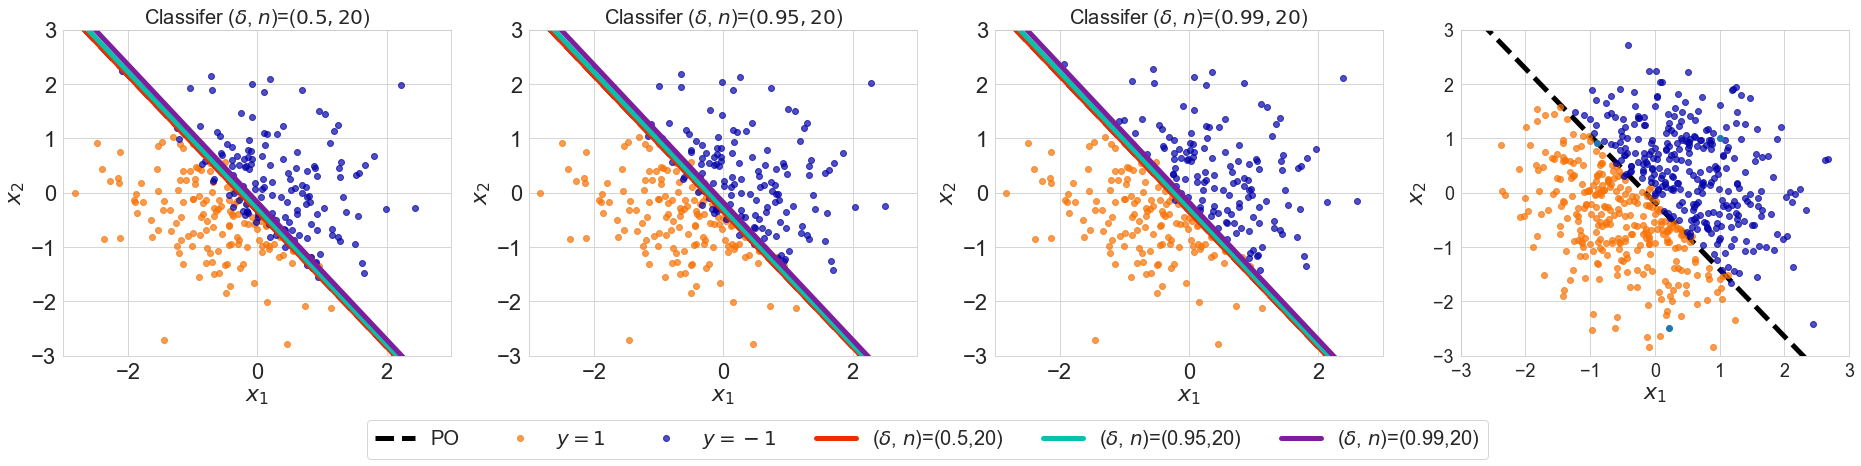

In [360]:
# plots all data distributions induced by the different classifiers with each of the learned classifiers
def classifier_plotter(X_test,y_test, classifiers, theta_final=theta_final, ax=ax):
    Xp = X_test[np.where(y_test==1)[0],0]
    Yp = X_test[np.where(y_test==1)[0],1]
    Xm = X_test[np.where(y_test==0)[0],0]
    Ym = X_test[np.where(y_test==0)[0],1]


    X1_PO, X2_PO=classifier_line(theta_final, bdd=(-3,3))
    cols_=['xkcd:tomato red', 'xkcd:turquoise', 'xkcd:purple', 'xkcd:hot pink']
    ax.plot(X1_PO,X2_PO, '--',label='PO', color='xkcd:black', linewidth=5)
    ax.plot(Xp,Yp,'.', markersize=12, color='xkcd:orange', label=r'$y=1$', alpha=0.7)
    ax.plot(Xm,Ym,'.',markersize=12, color='xkcd:royal blue', label=r'$y=-1$', alpha=0.7)
    #plt.plot(X1_Robust,X2_Robust)
    cols=['xkcd:golden rod', 'xkcd:tomato red', 'xkcd:purple', 'xkcd:hot pink']
    lss=['-','--','-.', ':']
    alphas=[0.6,0.7,0.9,1.0]
    for i,mixing in enumerate(deltas):
        col=cols_[i]
        for ii,n_epoch in enumerate(n_epochs):
            ls=lss[ii]
        
            (X1_PP, X2_PP)=classifiers[(mixing, n_epoch)]
            
            ax.plot(X1_PP,X2_PP, label='($\delta$, $n$)=({},{})'.format(mixing,n_epoch), linewidth=5, color=col, ls=lss[ii], alpha=1.0)
    #plt.plot(X1_PP_d, X2_PP_d)
    #plt.legend(['Data Points +1','Data Points -1','Static', 'Dynamic'])
    ax.plot(X1_PO,X2_PO, '--', color='xkcd:black', linewidth=5)

sns.set_style("whitegrid")    
fig,ax=plt.subplots(nrows=1,ncols=len(deltas)+1, figsize=(32,6), sharey=False)
for n_epoch in n_epochs:
    for i,mixing in enumerate(deltas):    
        X_perf = best_response(X_test ,2*y_test.reshape((N_test, 1))-1,theta_final_all[(mixing,n_epoch)], strat_features=strat_features,zeta=zeta)
        ax[i].plot
        #classifier_plotter(X_perf,y_test,classifiers,ax=ax[i])
        
        Xp = X_perf[np.where(y_test==1)[0],0]
        Yp = X_perf[np.where(y_test==1)[0],1]
        Xm = X_perf[np.where(y_test==0)[0],0]
        Ym = X_perf[np.where(y_test==0)[0],1]


        X1_PO, X2_PO=classifier_line(theta_final, bdd=(-3,3))
        cols_=['xkcd:tomato red', 'xkcd:turquoise', 'xkcd:purple', 'xkcd:hot pink']
        if i==0:
            ax[i].plot(X1_PO,X2_PO, '--',label='PO', color='xkcd:black', linewidth=5)

            ax[i].plot(Xp,Yp,'.', markersize=12, color='xkcd:orange', label=r'$y=1$', alpha=0.7)
            ax[i].plot(Xm,Ym,'.',markersize=12, color='xkcd:royal blue', label=r'$y=-1$', alpha=0.7)
        else:
            ax[i].plot(X1_PO,X2_PO, '--', color='xkcd:black', linewidth=5)

            ax[i].plot(Xp,Yp,'.', markersize=12, color='xkcd:orange', alpha=0.7)
            ax[i].plot(Xm,Ym,'.',markersize=12, color='xkcd:royal blue', alpha=0.7)
        #plt.plot(X1_Robust,X2_Robust)
        cols=['xkcd:golden rod', 'xkcd:tomato red', 'xkcd:purple', 'xkcd:hot pink']
        lss=['-','--','-.', ':']
        alphas=[0.6,0.7,0.9,1.0]
        for ind,mixing in enumerate(deltas):
            col=cols_[ind]
            for ii,n_epoch in enumerate(n_epochs):
                ls=lss[ii]

                (X1_PP, X2_PP)=classifiers[(mixing, n_epoch)]
                if i==0:
                    ax[i].plot(X1_PP,X2_PP, label='($\delta$, $n$)=({},{})'.format(mixing,n_epoch),
                               linewidth=5, color=col, ls=lss[ii], alpha=1.0)
                else:
                    ax[i].plot(X1_PP,X2_PP, 
                               linewidth=5, color=col, ls=lss[ii], alpha=1.0)

        ax[i].tick_params(labelsize=22)
        ax[i].set_xlabel(r'$x_1$', fontsize=22)
        ax[i].set_ylabel(r'$x_2$', fontsize=22)
        ax[i].set_xlim([-3,3])
        ax[i].set_ylim([-3,3])
ax[0].set_title(r'Classifer ($\delta$, $n$)=($0.5,20$)', fontsize=20)
ax[1].set_title(r'Classifer ($\delta$, $n$)=($0.95,20$)', fontsize=20)
ax[2].set_title(r'Classifer ($\delta$, $n$)=($0.99,20$)', fontsize=20)
X_test_=X_train #best_response(X_train ,2*y_train.reshape((N_train, 1))-1,theta_ground_truth, strat_features=strat_features,zeta=zeta)


Xp = X_test_[np.where(y_train==1)[0],0]
Yp = X_test_[np.where(y_train==1)[0],1]
Xm = X_test_[np.where(y_train==0)[0],0]
Ym = X_test_[np.where(y_train==0)[0],1]

X1_PO, X2_PO=classifier_line(theta_ground_truth, bdd=(-3,3))
ax[i+1].plot(X1_PO,X2_PO, color='xkcd:black', linewidth=5, linestyle='--')
ax[i+1].plot(Xp,Yp,'.', markersize=12, color='xkcd:orange', alpha=0.7)
ax[i+1].plot(Xm,Ym,'.',markersize=12, color='xkcd:royal blue', alpha=0.7)
ax[i+1].plot(X_full_[0], X_full_[1],'.', markersize=12)
ax[i+1].tick_params(labelsize=20)
ax[i+1].set_xlabel(r'$x_1$', fontsize=22)
ax[i+1].set_ylabel(r'$x_2$', fontsize=22)
ax[i+1].set_title(r'', fontsize=20)
ax[i+1].set_xlim([-3,3])
ax[i+1].set_ylim([-3,3])
fig.legend(fontsize=20, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=6) 

#plt.legend(fontsize=18, loc=1, bbox_to_anchor=(1.51,1))

plt.tick_params(labelsize=18)



for tag in ['pdf','png']:
    plt.savefig('classiferplot_d=2_N=1000_seed={}_nepoch={}_final'.format(seed,n_epoch)+'.'+tag, bbox_inches='tight', transparent=True, dpi=300)

## Plotting Confusion Matrix

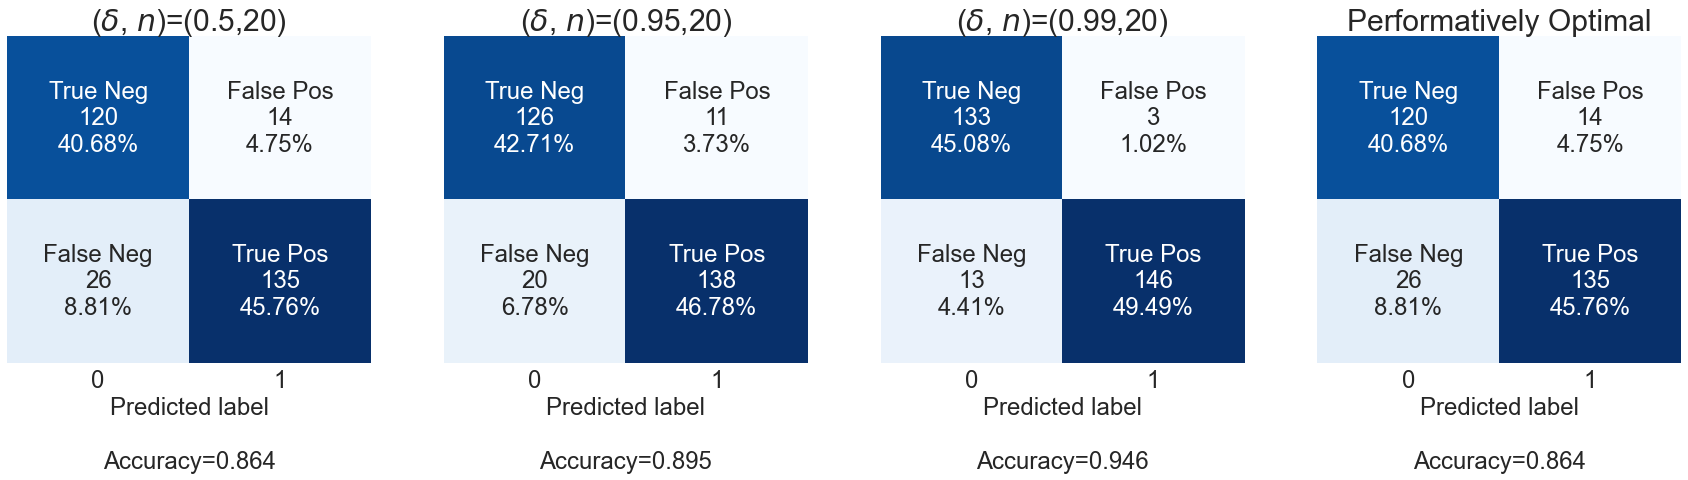

In [359]:



for n_epoch in n_epochs:
    fig,ax=plt.subplots(nrows=1,ncols=len(deltas)+1, figsize=(30,6))
    for i,mixing in enumerate(deltas):
        
        X_perf = best_response(X_test ,2*y_test.reshape((N_test, 1))-1,theta_final_all[(mixing,n_epoch)], strat_features=strat_features,zeta=zeta)
        cf_matrix=confusion_matrix((X_perf.dot(theta_final_all[(mixing,n_epoch)]) > 0),y_test)

        group_names = ['True Neg','False Pos','False Neg','True Pos']
        group_counts = ["{0:0.0f}".format(value) for value in
                        cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in
                             cf_matrix.flatten()/np.sum(cf_matrix)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
                  zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        mkcfmat(cf_matrix,group_names=group_names, verbose=False, ax=ax[i])
        ax[i].set_title(r'($\delta$, $n$)=({},{})'.format(mixing,n_epoch), fontsize=30)
        
    X_perf = best_response(X_test ,2*y_test.reshape((N_test, 1))-1,theta_final, strat_features=strat_features,zeta=zeta)
    cf_matrix=confusion_matrix((X_perf.dot(theta_final) > 0),y_test)
    mkcfmat(cf_matrix,group_names=group_names, verbose=False, ax=ax[i+1])
    ax[i+1].set_title(r'Performatively Optimal', fontsize=30)
    
for tag in ['pdf','png']:
    plt.savefig('confusion_d=2_N=1000_seed={}_nepoch={}_final'.format(seed,n_epoch)+'.'+tag, bbox_inches='tight', transparent=True, dpi=300)